In [271]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import deque
from scipy.signal import savgol_filter, detrend, correlate, find_peaks, sosfiltfilt, butter
from scipy.fft import fft, fftfreq
from hampel import hampel

## For CSI20250227_191018.csv

In [323]:
file_name = 'CSI20250227_191018.csv'

df = pd.read_csv(file_name)

# Convert string csi data (list of values) into array
df['csi_data'] = df['data'].apply(lambda x: np.array(literal_eval(x)))

# Convert the csi data from [imaginary_0, real_0, ...] into list of complex values [(real + imag*j),...]
df['csi_data_proc'] = df['csi_data'].apply(lambda x: [complex(x[i+1], x[i]) for i in range(0, len(x), 2)])

print(df['csi_data_proc'].describe())


count                                                  5004
unique                                                 5004
top       [(-88-23j), (-46-55j), (-70-55j), (-75-62j), (...
freq                                                      1
Name: csi_data_proc, dtype: object


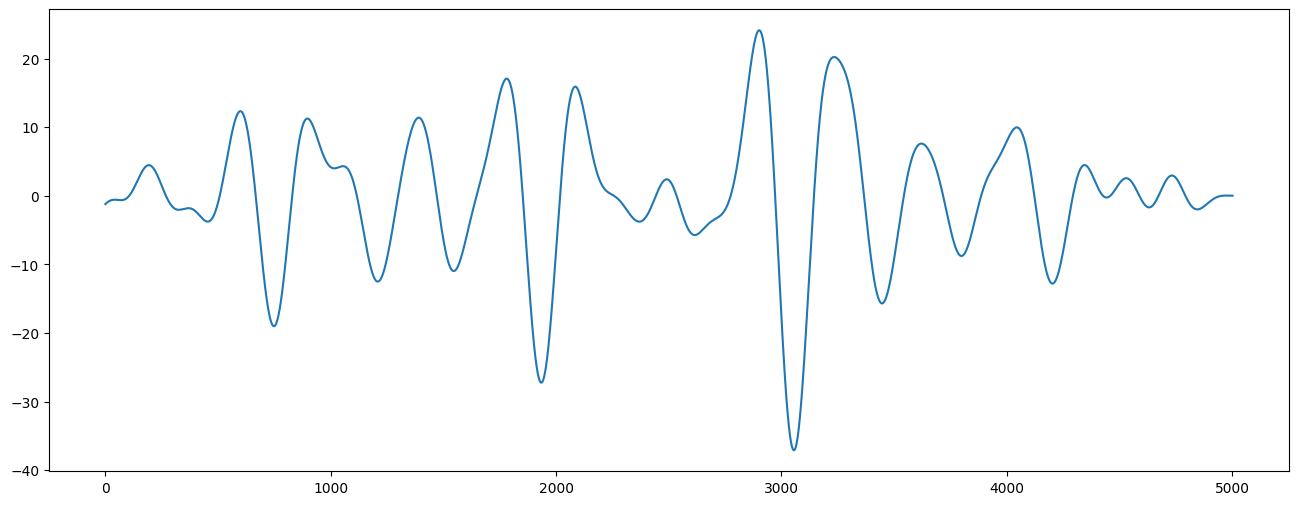

In [324]:
s_t_complex = [np.mean(csi_row[30:70]) for csi_row in df['csi_data_proc']]
s_t_complex = np.diff(s_t_complex)
s_t = signal.detrend(np.abs(s_t_complex))

plt.figure(figsize=(16,6))

# Raw Data
# plt.plot(s_t)

s_filt = savgol_filter(s_t, 200, 4)
s_filt = hampel(s_filt, window_size=10, n_sigma=3.0,).filtered_data

cutoff_freq = [0.15, 0.5]
sos = butter(3, cutoff_freq, "band", fs=100, output="sos")
s_filt = sosfiltfilt(sos, s_filt)


# Filtered Signal
plt.plot(s_filt)

In [325]:
fs = 100
b_t = []
window_length = 15
window_step = 1

window_n = int(window_length * fs)
counter = 0
for i in range(0, len(s_filt) - window_n + 1, int(window_step * fs)):
    window = s_filt[i : i + window_n]

    acf = correlate(window, window, mode='full')
    acf /= np.max(acf)
    acf = acf[acf.size // 2:]

    
    # Get peaks in acf to determine bpm
    try:
        x, _ = find_peaks(acf, height=0.01, prominence=0.05)
        br = fs / x[0] * 60
        if br < 8 or br > 20:
            plt.plot(x, acf[x], 'x')
            plt.plot(acf)
            if len(x) > 1:
                br = fs / x[1] * 60
            else:
                br = 15
            print(f"Did not get realistic BPM - putting {br} BPM")
    except IndexError:
        print("Unable to detect peak - defaulting to 15 BPM")
        br = 15

    # Append to result array
    b_t.append((df['timestamp'][i + window_n - 1][:19], br))
    counter += 1


In [326]:
for timestamp, br in b_t:
    print(timestamp, br)

2025-02-27 19:11:28 13.452914798206278
2025-02-27 19:11:29 13.856812933025404
2025-02-27 19:11:30 14.084507042253522
2025-02-27 19:11:31 15.151515151515152
2025-02-27 19:11:32 15.424164524421593
2025-02-27 19:11:33 15.113350125944585
2025-02-27 19:11:34 15.267175572519085
2025-02-27 19:11:35 15.503875968992247
2025-02-27 19:11:36 16.0427807486631
2025-02-27 19:11:37 16.0
2025-02-27 19:11:38 16.216216216216218
2025-02-27 19:11:39 16.129032258064516
2025-02-27 19:11:40 16.172506738544474
2025-02-27 19:11:41 15.915119363395227
2025-02-27 19:11:42 16.172506738544474
2025-02-27 19:11:43 15.873015873015872
2025-02-27 19:11:44 15.748031496062993
2025-02-27 19:11:45 16.0857908847185
2025-02-27 19:11:46 16.304347826086957
2025-02-27 19:11:48 15.748031496062993
2025-02-27 19:11:49 15.625000000000002
2025-02-27 19:11:50 15.584415584415583
2025-02-27 19:11:51 15.503875968992247
2025-02-27 19:11:52 15.625000000000002
2025-02-27 19:11:53 15.625000000000002
2025-02-27 19:11:54 15.706806282722512
2025

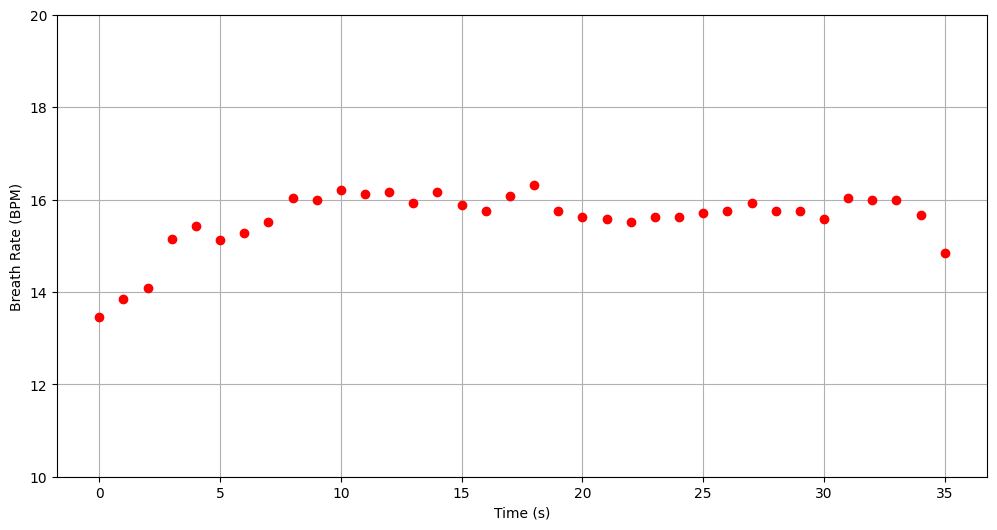

In [327]:
plt.figure(figsize=(12,6))
plt.ylabel("Breath Rate (BPM)")
plt.xlabel("Time (s)")
plt.ylim(10, 20)
plt.grid()
plt.plot([x[1] for x in b_t], "or")

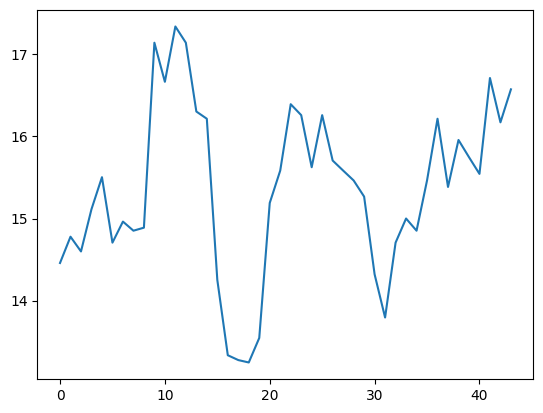

In [328]:
gt_file_name = "gt_" + file_name[3:]
df_gt = pd.read_csv(gt_file_name)
plt.plot(df_gt['bpm'])

In [331]:
def calculate_mae(ground_truth, predictions) -> float:
    # Convert inputs to numpy arrays if they aren't already
    y_true = np.asarray(ground_truth)
    y_pred = np.asarray(predictions)
    
    # Input validation
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Input shapes don't match. Ground truth: {y_true.shape}, Predictions: {y_pred.shape}")
    
    # Calculate absolute errors
    absolute_errors = np.abs(y_true - y_pred)
    
    # Compute MAE
    mae = np.mean(absolute_errors)

    return mae

pred = [x[1] for x in b_t]
gt = df_gt['bpm']
print(f"MAE: {calculate_mae(pred, gt[:36])}") # To make dimensions match (ground truth sometimes has multiple readings for same timestamp)

MAE: 0.8967166043706766


## For CSI20250227_193124.csv

(Omitting visualization)

MAE: 1.8777131232784403


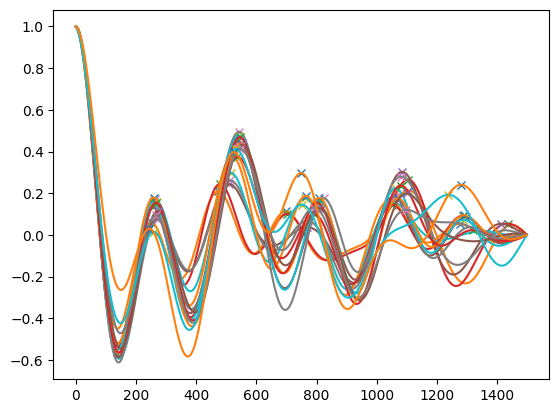

In [334]:
file_name = 'CSI20250227_193124.csv'

df = pd.read_csv(file_name)

# Convert string csi data (list of values) into array
df['csi_data'] = df['data'].apply(lambda x: np.array(literal_eval(x)))

# Convert the csi data from [imaginary_0, real_0, ...] into list of complex values [(real + imag*j),...]
df['csi_data_proc'] = df['csi_data'].apply(lambda x: [complex(x[i+1], x[i]) for i in range(0, len(x), 2)])

# Process the CSI data
s_t_complex = [np.mean(csi_row[30:70]) for csi_row in df['csi_data_proc']]
s_t_complex = np.diff(s_t_complex)
s_t = signal.detrend(np.abs(s_t_complex))

# Filter the data
s_filt = savgol_filter(s_t, 200, 4)
s_filt = hampel(s_filt, window_size=10, n_sigma=3.0,).filtered_data
cutoff_freq = [0.15, 0.5]
sos = butter(3, cutoff_freq, "band", fs=100, output="sos")
s_filt = sosfiltfilt(sos, s_filt)

# Sliding window ACF to estimate BPM

fs = 100
b_t = []
window_length = 15
window_step = 1

window_n = int(window_length * fs)
counter = 0
for i in range(0, len(s_filt) - window_n + 1, int(window_step * fs)):
    window = s_filt[i : i + window_n]

    acf = correlate(window, window, mode='full')
    acf /= np.max(acf)
    acf = acf[acf.size // 2:]

    
    # Get peaks in acf to determine bpm
    try:
        x, _ = find_peaks(acf, height=0.01, prominence=0.05)
        br = fs / x[0] * 60
        if br < 8 or br > 20:
            plt.plot(x, acf[x], 'x')
            plt.plot(acf)
            if len(x) > 1:
                br = fs / x[1] * 60
            else:
                br = 15
            # print(f"Did not get realistic BPM - putting {br} BPM")
    except IndexError:
        # print("Unable to detect peak - defaulting to 15 BPM")
        br = 15

    # Append to result array
    b_t.append((df['timestamp'][i + window_n - 1][:19], br))
    counter += 1

pred = [x[1] for x in b_t]
gt_file_name = "gt_" + file_name[3:]
df_gt = pd.read_csv(gt_file_name)
gt = df_gt['bpm']
print(f"MAE: {calculate_mae(pred, gt[:57])}") # To make dimensions match (ground truth sometimes has multiple readings for same timestamp)